# TFM 



## Preparing data

### Mounting Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


### Generating files

In [1]:
import pandas as pd 
import numpy as np

save_datetime = True
save_cell_traffic = True
save_normalized = True
save_all_traffic = True

cell_name = 'Cell_000111'

# path of csv files
dst_path = '/content/drive/My Drive/TFM/data/train.csv'

nRowsRead = None # specify 'None' if want to read whole file

df1 = pd.read_csv(dst_path, delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'dataset.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')
pd.set_option('max_colwidth', 1000,'display.max_rows', 20)

# To datetime
df1.Date = df1.Date.str.split(' ').str[0].str.strip()
df1['Date'] = pd.to_datetime(df1['Date'])

#Sorting DataFrame
df1 = df1.sort_values(by =['CellName','Date','Hour'])
df1 = df1.reset_index(drop=True)

# Chosing cell
is_cell = df1['CellName']== cell_name
traffic = df1[is_cell]
data_cell = traffic.loc[:,'Traffic']

if save_cell_traffic:
  
    np.save('/content/drive/My Drive/TFM/data/data_cell.npy', data_cell)
    print('data cell has been saved as npy file')

# Save traffic from all data cell to npy file     
if save_all_traffic:

    alldata_cell = df1.loc[:,'Traffic']
    np.save('/content/drive/My Drive/TFM/data/alldata_cell.npy', alldata_cell)
    print('all data cell has been saved as npy file')

# Save date-time as npy file    
if save_datetime:
    
    date_time = traffic.loc[:,'Date']
    np.save('/content/drive/My Drive/TFM/data/date-time.npy', date_time)
    print('date-time have been saved as npy file')

# Save normalized data cell to npy file    
if save_normalized:
    
    mu = np.mean(data_cell)
    std = np.std(data_cell)

    normalized_data_cell = (data_cell - mu) / std
    np.save('/content/drive/My Drive/TFM/data/normalized_data_cell.npy', normalized_data_cell)
    print('normalized data cell has been saved as npy file')

# Read traffic-matrices data
# Traffic_matrices = np.load('/content/drive/My Drive/TFM/data/traffic-matrices.npy')
# print('=='*30)
# normalized_traffic_matrices = np.load('/home/hyx/Pytorch/Traffic_prediction/data/normalized-traffic-matrices.npy')
# print(normalized_traffic_matrices[0][0]*std+mu)

FileNotFoundError: ignored

### Libraries

In [0]:
#importing the libraries

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

#%matplotlib inline

import time
import os


#Pytorch
import random
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib as mpl 
from torch import nn, optim
import scipy.io as sio 

#Greedy
from itertools import product



## LSTM

### Prepro data

In [0]:
#@title Hyperparameters { run: "auto", form-width: "30%", display-mode: "both" }
import numpy as np
import pandas as pd

# Load data and process data
data_path = '/content/drive/My Drive/TFM/data/data_cell.npy'
save_dir = '/content/drive/My Drive/TFM/model/'

raw_data = np.load(data_path) 
new_data = np.load(data_path) 

print('raw data',raw_data)
print('len raw data',len(raw_data))

# We now define the network
# Hyperparameters used in the network
epochs = 200 #@param {type:"integer"}
learning_rate = 0.001 #@param {type:"number"}
batch_size = 64 #@param {type:"number"} #how many windows of data we are passing at once
window_size = 24 #@param {type:"number"} #how big window_size is 
hidden_layer = 256 #@param {type:"number"} #How many units do we use in LSTM cell
clip_margin = 4 #@param {type:"number"} #To prevent exploding gradient, we use clipper to clip gradients below -margin or above this margin
    
max_data = np.max(new_data)
min_data = np.min(new_data)

# Applying Min-Max scaling: [0,1]
  # print(new_data)
new_data = (new_data-min_data)/(max_data-min_data)

print('Normalized data', new_data)
print ('Data len after normalizing: ', new_data.size) 

# Window the data and divide it into training and test sets.

df = pd.DataFrame({'temp':new_data})
pd.set_option('max_colwidth', 1000,'display.max_rows', 6)

# define function for create N lags
def create_lags(df, N):
    for i in range(N):
        df['Lag ' + str(i+1) ] = df.temp.shift(i+1)
    return df

# create time-windows lags
df = create_lags(df,window_size)

# the first 24 samples will have missing values. can't use them. (lagging)
df = df.dropna()
display(df)
# create X and y (matrix)
y = df.temp.values
X = df.iloc[:, 1:].values

# Train on 70% of the data
train_idx = int(len(df) * .7)

# create train and test data
train_X, train_Y, test_X, test_Y = X[:train_idx], y[:train_idx], X[train_idx:], y[train_idx:]
print('the total number of data', len(new_data))
print('the number of train data: ', len(train_X))
print('the number of test data: ', len(test_X))
print('the shape of input (train_X): ', train_X.shape)
print('the shape of target (train_Y): ', train_Y.shape)

raw data [  29.2649    19.2617    18.37236 ... 1214.65022  813.53021  865.37949]
len raw data 8733
Normalized data [0.00355711 0.00233726 0.00222881 ... 0.1481103  0.09919525 0.10551807]
Data len after normalizing:  8733


,temp,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Lag 6,Lag 7,Lag 8,Lag 9,Lag 10,Lag 11,Lag 12,Lag 13,Lag 14,Lag 15,Lag 16,Lag 17,Lag 18,Lag 19,Lag 20,Lag 21,Lag 22,Lag 23,Lag 24
24,0.001965,0.005000,0.008445,0.039942,0.062190,0.080918,0.076701,0.015330,0.057681,0.037768,0.014772,0.032418,0.030067,0.056843,0.016680,0.029155,0.029416,0.036538,0.047377,0.008200,0.002626,0.002268,0.002229,0.002337,0.003557
25,0.000379,0.001965,0.005000,0.008445,0.039942,0.062190,0.080918,0.076701,0.015330,0.057681,0.037768,0.014772,0.032418,0.030067,0.056843,0.016680,0.029155,0.029416,0.036538,0.047377,0.008200,0.002626,0.002268,0.002229,0.002337
26,0.000270,0.000379,0.001965,0.005000,0.008445,0.039942,0.062190,0.080918,0.076701,0.015330,0.057681,0.037768,0.014772,0.032418,0.030067,0.056843,0.016680,0.029155,0.029416,0.036538,0.047377,0.008200,0.002626,0.002268,0.002229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8730,0.148110,0.684775,0.480708,0.338111,0.261703,0.263769,0.116371,0.181477,0.152238,0.231192,0.119742,0.050515,0.037604,0.130667,0.033095,0.084732,0.014740,0.014086,0.004625,0.019159,0.007343,0.072444,0.070213,0.084304,0.359740
8731,0.099195,0.148110,0.684775,0.480708,0.338111,0.261703,0.263769,0.116371,0.181477,0.152238,0.231192,0.119742,0.050515,0.037604,0.130667,0.033095,0.084732,0.014740,0.014086,0.004625,0.019159,0.007343,0.072444,0.070213,0.084304
8732,0.105518,0.099195,0.148110,0.684775,0.480708,0.338111,0.261703,0.263769,0.116371,0.181477,0.152238,0.231192,0.119742,0.050515,0.037604,0.130667,0.033095,0.084732,0.014740,0.014086,0.004625,0.019159,0.007343,0.072444,0.070213


the total number of data 8733
the number of train data:  6096
the number of test data:  2613
the shape of input (train_X):  (6096, 24)
the shape of target (train_Y):  (6096,)


### Plotting traffic

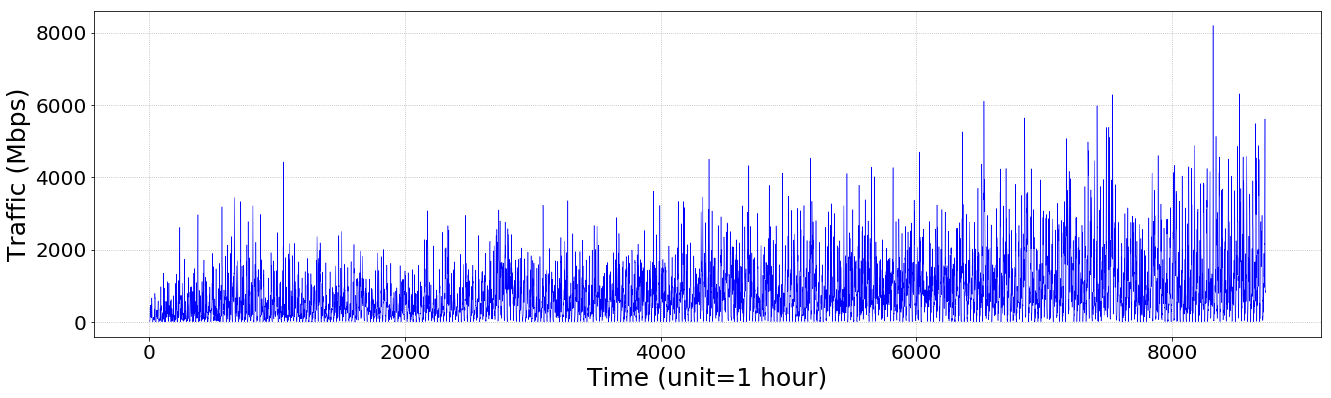

In [0]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

#plotting the data

fig = plt.figure(figsize=(22,6))
ax1 = fig.add_subplot(111)
ax1.plot(raw_data, color='blue', linewidth=0.5)
ax1.tick_params(labelsize=20) 
ax1.grid(True, linestyle = ":") 
ax1.set_ylabel('Traffic (Mbps)', fontsize=25)
ax1.set_xlabel('Time (unit=1 hour)', fontsize=25)

plt.savefig('/content/drive/My Drive/TFM/graphs/raw_traffic.png', format='png', dpi=600)
plt.savefig('/content/drive/My Drive/TFM/graphs/raw_traffic.pdf', format='pdf', dpi=1000)


### Defining LSTM network

In [0]:
import tensorflow as tf
import numpy as np

#we define the placeholders

inputs = tf.placeholder(tf.float32, [batch_size, window_size])
targets = tf.placeholder(tf.float32, [batch_size])


# Implementation of LSTM cell
# LSTM weights

#Weights for the input gate layer'i1'):
with tf.variable_scope('i1'):
  weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
  weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
  bias_input = tf.Variable(tf.zeros([hidden_layer]))
  #variable_summaries(weights_input_gate)
  
#weights for the forgot layer
with tf.variable_scope('f1'):
  weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
  weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
  bias_forget = tf.Variable(tf.zeros([hidden_layer]))

#weights for the output layer
with tf.variable_scope('o1'):
  weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
  weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
  bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the input update
with tf.variable_scope('iu'):
  weights_input_update = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
  weights_input_update_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
  bias_input_update = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
with tf.variable_scope('ol'):
  weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
  bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):
    
    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)
    
    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)
    
    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)
    
    input_update = tf.tanh(tf.matmul(input, weights_input_update) + tf.matmul(output, weights_input_update_hidden) + bias_input_update)
    
    state = state * forget_gate + input_gate * input_update
    
    output = output_gate * tf.tanh(state)
    return state, output
  
  
# Loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch
    #for each batch a batch_state is created as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32) 
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)
    
    #for each point in the window we are feeding that into LSTM to get next output
    for j in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][j], (-1, 1)), batch_state, batch_output)
        
    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)


### Training network

In [0]:
import tensorflow as tf

# loss
losses = []

for i in range(len(outputs)):
  losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))
  

loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)

trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

sess = tf.Session()

#we now train the network
sess.run(tf.global_variables_initializer())

mean_loss = []
for i in range(epochs):
    traind_scores = []
    j = 0
    epoch_loss = []
    while(j + batch_size) <= len(train_X):
        X_batch = train_X[j:j+batch_size]
        y_batch = train_Y[j:j+batch_size]
        
        o, c, _ = sess.run([ outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})
       
        epoch_loss.append(c)
        traind_scores.append(o)
        j += batch_size
    if (i % 30) == 0:    
      print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))
    
    mean_loss.append(np.mean(epoch_loss))    
    

# Saving the model
saver = tf.train.Saver()
# Save the model once per iteration


if os.path.exists(save_dir):
    saver.save(sess, save_dir,global_step=25,write_meta_graph=False)
else:
    os.makedirs(save_dir)
    saver.save(sess, save_dir,global_step=25,write_meta_graph=False)

W0730 12:11:11.179394 140290686412672 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 0/100  Current loss: 0.004453956615179777
Epoch 30/100  Current loss: 0.002934632822871208
Epoch 60/100  Current loss: 0.0028432796243578196
Epoch 90/100  Current loss: 0.0027306117117404938


### Plot RMS loss

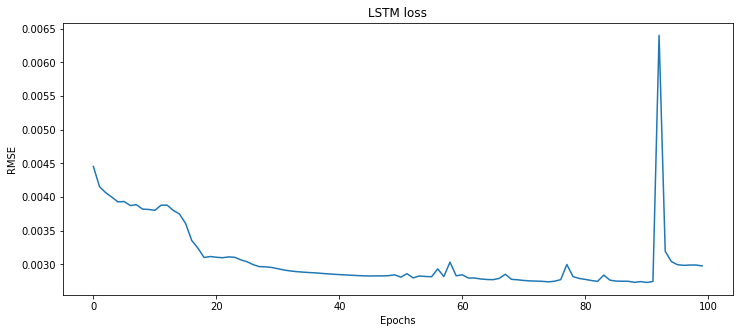

In [0]:
# Plotting RMSE loss

plt.figure(figsize=(12, 5))
plt.title('LSTM loss')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.plot(mean_loss)



plt.savefig('/content/drive/My Drive/TFM/graphs/LSTM_rmse_loss.png', format='png', dpi=600)
plt.savefig('/content/drive/My Drive/TFM/graphs/LSTM_rmse_loss.eps', format='eps', dpi=1000)

plt.show()

### Test

In [0]:
#Testing the results from the network

train_result =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        train_result.append(traind_scores[i][j][0])               
        
tests = []
i = 0
while i+batch_size <= len(test_X): 
  
    o = sess.run([ outputs],feed_dict={inputs:test_X[i:i+batch_size]})
    i += batch_size
    tests.append(o)

    
tests_new = []
for i in range(len(tests)):
     for j in range(len(tests[i][0])):
        tests_new.append(tests[i][0][j])
        

test_results = []
for i in range(len(new_data)-100):
      if i >= len(train_X):
        test_results.append(tests_new[i-len(train_X)])
      else:
        test_results.append(None)
        

### Actual vs Prediction

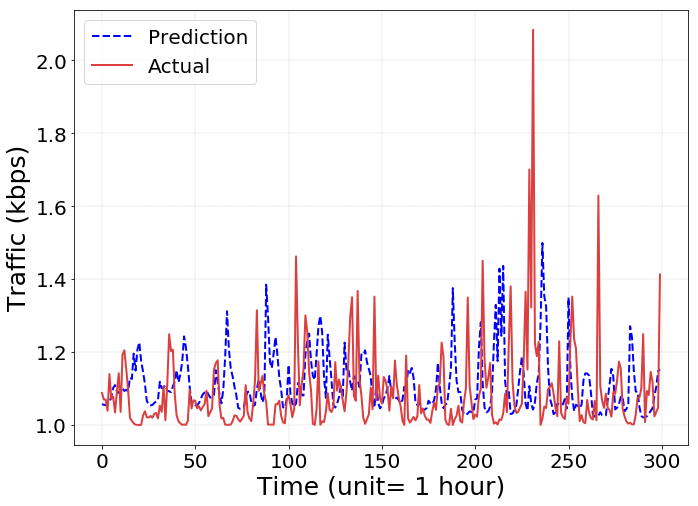

In [0]:
import matplotlib.pyplot as plt
from matplotlib import gridspec


# Plot actual traffic vs predicted traffic

act = new_data[7:]

prediction = [10**m for m in train_result]
actual  = [10**n for n in act]

fig = plt.figure(figsize=(11,8))
ax = fig.add_subplot(111)
ax.plot(prediction[:300], color='blue', linestyle='--', linewidth=2, label='Prediction')
ax.plot(actual[:300], color='#db3f3f', linewidth=2, label='Actual')
ax.set_xlabel('Time (unit= 1 hour)', fontsize=25)
ax.set_ylabel('Traffic (kbps)', fontsize=25)
ax.tick_params(labelsize=20)
plt.legend(fontsize=20)
ax.grid(True, linestyle = "--", lw=0.3) 

plt.savefig('/content/drive/My Drive/TFM/graphs/Prediction_actual.png', format='png', dpi=600)
plt.savefig('/content/drive/My Drive/TFM/graphs/Prediction_actual.eps', format='eps', dpi=1000)


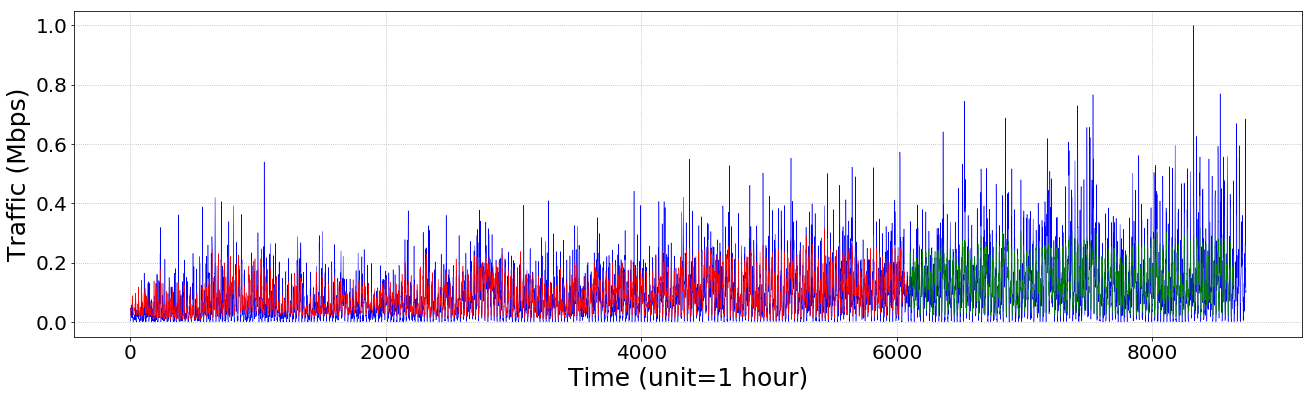

In [0]:
import matplotlib.pyplot as plt
from matplotlib import gridspec


# Actual vs Predictions from the network

fig = plt.figure(figsize=(22,6))
ax1 = fig.add_subplot(111)
ax1.plot(new_data, color='blue', linewidth=0.5)
ax1.plot(train_result, color='red', linewidth=0.5)
ax1.plot(test_results, color='green', linewidth=0.5)

ax1.tick_params(labelsize=20) 
ax1.grid(True, linestyle = ":") 
ax1.set_ylabel('Traffic (Mbps)', fontsize=25)
ax1.set_xlabel('Time (unit=1 hour)', fontsize=25)

plt.savefig('/content/drive/My Drive/TFM/graphs/raw_traffic.png', format='png', dpi=600)
plt.savefig('/content/drive/My Drive/TFM/graphs/raw_traffic.pdf', format='pdf', dpi=1000)


### Comparison with models

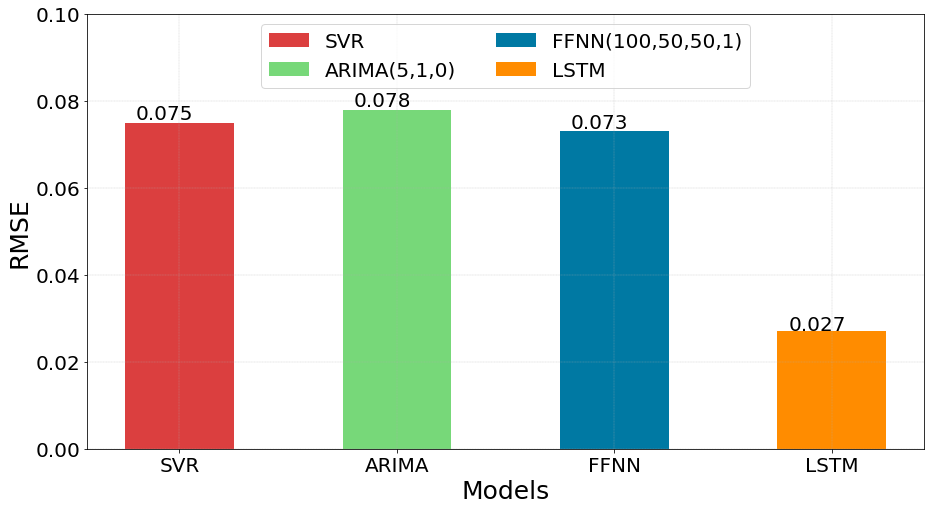

In [0]:
# Comparison with other predicition models

ARIMA = 0.078
SVR = 0.075
FFNN = 0.073
LSTM = 0.027

y = [SVR, ARIMA, FFNN, LSTM]

fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)
x = [0.6, 1.2, 1.8, 2.4]
width = 0.3
ax1.bar(x[0], y[0], width=width, label='SVR',fc = '#db3f3f')
ax1.text(x[0]-0.12, 1.01*y[0], str(y[0]), fontsize=20)
ax1.bar(x[1], y[1], width=width, label='ARIMA(5,1,0)',fc = '#77d879')  
ax1.text(x[1]-0.12, 1.01*y[1], str(y[1]), fontsize=20)
ax1.bar(x[2], y[2], width=width, label='FFNN(100,50,50,1)',fc = '#0079a3')
ax1.text(x[2]-0.12, 1.01*y[2], str(y[2]), fontsize=20)
ax1.bar(x[3], y[3], width=width, label='LSTM',fc = '#FF8C00')
ax1.text(x[3]-0.12, 1.01*y[3], str(y[3]), fontsize=20)


plt.xticks(x, ['SVR', 'ARIMA','FFNN', 'LSTM'])
ax1.set_ylim([0, 0.1])
ax1.tick_params(labelsize=20) 
ax1.set_ylabel('RMSE', fontsize=25)
ax1.set_xlabel('Models', fontsize=25)
ax1.grid(True, linestyle = "--", lw=0.3)

ax1.legend(loc='upper center', ncol=2, fontsize=20) 

plt.savefig('/content/drive/My Drive/TFM/graphs/Comparison.png', format='png', dpi=600)
#plt.savefig('/content/drive/My Drive/TFM/graphs/Comparison.eps', format='eps', dpi=1000)
plt.show()

## Bandwidth allocation problem

In [0]:
import numpy as np
import random
import pandas as pd
!pip install numpy==1.16.1


def generate_random_integers(_sum, n):  
    

    min_v = 0
    max_v = _sum
    array = [min_v] * n

    diff = _sum - min_v * n
    while diff > 0:
        a = random.randint(0, n - 1)
        if array[a] >= max_v:
            continue
        array[a] += 1
        diff -= 1
    return array


# Denrmalizinf traffic
def denormalize(norm,data):
    
  max_data = np.max(data)
  min_data = np.min(data)
  value = (norm*(max_data-min_data))+min_data
 
  return value  

# test = []
# train = []

# test.clear()
# train.clear()

# test = test_results.copy()
# train = train_result.copy()

# test = [i for i in test if i is not None]

# print('len train_result',len(train))
# print('len tests_results',len(test))

# train.extend(test)

# np.save('/content/drive/My Drive/TFM/data/predicted_traffic.npy', train)
# print('The traffic predicted was save')


# loading old for denormalizing function traffic
data = np.load('/content/drive/My Drive/TFM/data/data_cell.npy')

# loading predicting traffic
predict = np.load('/content/drive/My Drive/TFM/data/predicted_traffic.npy') 

print('normalize data', predict)
print(len(predict))
predict = predict[predict > 0]
print(len(predict))

# predict[predict < 0] = 0
max_dat = np.max(predict)
min_dat = np.min(predict)
print(max_dat)
print(min_dat)

train =[]
for i in range(len(predict)):
  
  train.append(denormalize(predict[i],data))

print('denormalize data', train)


print('len data',len(train))

data_max = max(train)
data_min = min(train) 

print('data_max',data_max)
print('data_min',data_min)

# Bandwdth allocation problem
bw1 = []
bw2 = []
bw3 = []

users = 3
tasks = 3
total_users = 50
user_index=['sum tasks user%d'%(i+1) for i in range(users)]

task_index = []

for i in range(users):
  for j in range(tasks):
      task_index.append('user%d'%(i+1) +' task%d'%(j+1))

print(task_index)      
      
data_tasks = np.zeros((len(train), users*tasks))
BW_users = np.zeros((users, len(train)))

n = users*tasks

data_users = [x / total_users for x in train]

print(data_users)

data_users = [x * users for x in data_users]
print(data_users)


# Generating random tasks

for i in range(len(data_users)):

    sampl = generate_random_integers(data_users[i],n) 
    data_tasks[i] = sampl  # creating data tasks
    bw1.append(sum(data_tasks[i][0:3]))  # creating bw_users
    bw2.append(sum(data_tasks[i][3:6]))
    bw3.append(sum(data_tasks[i][6:9]))
    
BW_users = np.array((bw1, bw2, bw3), dtype=float)
    
#print(BW_users)
    
df_tasks = pd.DataFrame(data_tasks,columns=task_index)    
print('Matrix with tasks_size',len(data_tasks))


max_data = np.max(data_tasks)
min_data = np.min(data_tasks)
print(max_data)
print(min_data)

df_bw = pd.DataFrame(BW_users,index=user_index)

display(df_tasks)
print('BW per user at each t')
display(df_bw)

# Save a csv file and npy file
np.savetxt("/content/drive/My Drive/TFM/offloading_data/task_size.csv", data_tasks, delimiter=",")
np.save('/content/drive/My Drive/TFM/offloading_data/task_size.npy', data_tasks)

np.savetxt("/content/drive/My Drive/TFM/offloading_data/bw_users.csv", BW_users, delimiter=",")
np.save('/content/drive/My Drive/TFM/offloading_data/bw_users.npy', BW_users)




normalize data [[0.019230294972658157]
 [0.018242981284856796]
 [0.023143772035837173]
 ...
 [0.14005859196186066]
 [0.08608222007751465]
 [0.09011202305555344]]
8525
8429
0.5875139236450195
4.917383193969727e-07
denormalize data [157.79035880681414, 149.6940507913309, 189.8822016592965, 172.45147949861064, 219.51738338666422, 228.8321547516006, 349.0599612613547, 352.6890794729661, 298.32012429598126, 289.9833373283119, 289.95385788358885, 325.2408754116304, 290.6817099560973, 315.1691391132311, 275.10648208870816, 418.9642172236012, 411.30664888180917, 501.5132609558846, 468.5915640972875, 558.7293500688129, 569.5311073936846, 1058.8906229633124, 367.4965281857194, 370.4135574268712, 277.54246177954565, 154.1058253488529, 180.95292367566557, 211.75121460343138, 193.04927157926477, 210.62946827158765, 210.92484314311807, 363.58758436409465, 356.5743786415177, 372.3217481369008, 365.51593718139594, 344.09412588627686, 354.72041178059004, 273.8622051322178, 358.5274453145505, 379.856816

,user1 task1,user1 task2,user1 task3,user2 task1,user2 task2,user2 task3,user3 task1,user3 task2,user3 task3
0,1.0,2.0,2.0,0.0,0.0,3.0,0.0,1.0,1.0
1,0.0,0.0,1.0,2.0,1.0,3.0,0.0,1.0,1.0
2,1.0,0.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0
3,0.0,3.0,0.0,1.0,3.0,1.0,1.0,0.0,2.0
4,2.0,0.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0
5,2.0,2.0,1.0,3.0,3.0,1.0,1.0,0.0,1.0
6,6.0,0.0,1.0,3.0,3.0,2.0,2.0,2.0,2.0
7,2.0,3.0,3.0,3.0,3.0,2.0,1.0,3.0,2.0
8,4.0,1.0,1.0,5.0,3.0,2.0,0.0,2.0,0.0
9,3.0,1.0,1.0,2.0,3.0,4.0,2.0,0.0,2.0


BW per user at each t


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,8389,8390,8391,8392,8393,8394,8395,8396,8397,8398,8399,8400,8401,8402,8403,8404,8405,8406,8407,8408,8409,8410,8411,8412,8413,8414,8415,8416,8417,8418,8419,8420,8421,8422,8423,8424,8425,8426,8427,8428
sum tasks user1,5.0,1.0,3.0,3.0,4.0,5.0,7.0,8.0,6.0,5.0,3.0,6.0,4.0,8.0,4.0,5.0,7.0,9.0,7.0,12.0,12.0,21.0,11.0,5.0,6.0,6.0,4.0,3.0,2.0,4.0,2.0,5.0,10.0,6.0,10.0,7.0,9.0,5.0,6.0,12.0,...,13.0,39.0,7.0,2.0,10.0,6.0,4.0,10.0,13.0,15.0,10.0,30.0,31.0,32.0,30.0,17.0,19.0,18.0,12.0,18.0,20.0,24.0,63.0,45.0,30.0,15.0,5.0,5.0,10.0,4.0,7.0,10.0,18.0,33.0,13.0,14.0,19.0,20.0,13.0,12.0
sum tasks user2,3.0,6.0,5.0,5.0,6.0,7.0,8.0,8.0,10.0,9.0,5.0,9.0,9.0,6.0,8.0,12.0,7.0,12.0,12.0,9.0,12.0,26.0,3.0,8.0,6.0,2.0,4.0,5.0,3.0,2.0,7.0,7.0,5.0,12.0,8.0,9.0,4.0,5.0,10.0,5.0,...,17.0,35.0,17.0,17.0,2.0,5.0,6.0,8.0,11.0,11.0,17.0,8.0,53.0,41.0,17.0,31.0,14.0,11.0,13.0,22.0,16.0,27.0,52.0,52.0,20.0,25.0,9.0,6.0,6.0,7.0,10.0,8.0,9.0,32.0,15.0,29.0,21.0,27.0,15.0,17.0
sum tasks user3,2.0,2.0,4.0,3.0,4.0,2.0,6.0,6.0,2.0,4.0,10.0,5.0,5.0,5.0,5.0,9.0,11.0,10.0,10.0,13.0,11.0,17.0,9.0,10.0,5.0,2.0,3.0,5.0,7.0,7.0,4.0,10.0,7.0,5.0,4.0,5.0,9.0,7.0,6.0,6.0,...,25.0,34.0,14.0,5.0,2.0,5.0,7.0,11.0,8.0,17.0,15.0,21.0,34.0,30.0,27.0,20.0,15.0,13.0,19.0,24.0,23.0,21.0,48.0,42.0,22.0,17.0,5.0,3.0,6.0,3.0,9.0,10.0,13.0,26.0,15.0,20.0,29.0,22.0,15.0,16.0


In [0]:
print(BW_users)

[[ 5.  1.  3. ... 20. 13. 12.]
 [ 3.  6.  5. ... 27. 15. 17.]
 [ 2.  2.  4. ... 22. 15. 16.]]


## MEC

### Prepro data

In [0]:
#@title Hyperparameters { run: "auto", form-width: "30%", display-mode: "both" }

import numpy as np

np.random.seed(4)

task_size = np.load('/content/drive/My Drive/TFM/offloading_data/task_size/task_size.npy')

gain = np.load('/content/drive/My Drive/TFM/offloading_data/task_size/gain.npy')

BW_users = np.load('/content/drive/My Drive/TFM/offloading_data/task_size/bw_users.npy')
# task_size = data_tasks.copy()

num_train = int(.7* len(task_size))

N = len(task_size)
print('Total data size', N)
num_test = (len(task_size) - train_idx) # training data size
print('the number of train data: ', num_train)
print('the number of test data: ', num_test)

# Pytorch Neural Network 
users = 3 #@param {type:"number"}
tasks = 3  #@param {type:"number"}
net_num = 4  #@param {type:"number"}
batch_size = 128 #@param {type:"number"}
input_size = 9 #@param {type:"number"}
hidden_size1 = 120 #@param {type:"number"}
hidden_size2 = 80 #@param {type:"number"}
output_size = 9#@param {type:"number"}
mem_size = 1024 #@param {type:"number"}
training_interval=10 #@param {type:"number"}

Total data size 8429
the number of train data:  5900
the number of test data:  2333


### Training network

In [0]:
import time

# Training network
users = 3 
tasks = 3
# Defining cross entropy loss
def compute_loss(logits, labels):
    
    a = - labels
    b = torch.log10(logits)
    c = (1 - labels)
    d = torch.log10(1-logits)
    loss = (a*b - c*d)
    loss[torch.isnan(loss)] = 0
    loss = torch.mean(loss)
    
    return loss


#construct 3 same nets
net = []
for i in range(net_num):
    net.append(NN(input_size, hidden_size1, hidden_size2, output_size, batch_size, mem_size, net_num))

util = compute_Off(users,tasks)
optimizer = []
    
  
for k in range (net_num):
    optimizer.append(torch.optim.SGD(net[k].parameters(), lr=1e-4, momentum=0.9))

array_loss = []
gain_min = []
gain_ratio = []
gain_pos = []
system_loss = [1,]
start_time=time.time()    

task_size = task_size.astype(int)
# split_idx = int(.7* len(task_size))
print(task_size)

print('The memory is starting to feed')
for i in range(3000): 
    if i < N - num_test:
        #training
        index = i % num_train
    else:
        # test
        index = i - N + num_test + num_train

    t1 = task_size[index,:]
    
#     t = t1*10-20
 
    if i % (N//100) == 0:
#           print(t)
       print(t1)
    x = (torch.FloatTensor([t1]))
    
    dec_list1 =[]
    for j in range(net_num):
    #Here it is obtained the result of the network  
         
        dec_list = net[j](x).detach().numpy()
        if i % (N//100) == 0:   
            print('NN:', j,dec_list)
        #logits.append(dec_list)
        dec_list1.append(1*(dec_list[0]>0.5))
        

    if i % (N//100) == 0:
         print('offloading dec', dec_list1)
    
    util_list = []
    bw_list = []
    
    for m in dec_list1:
        # Bandwidth allocation problem: (P2) : Q∗(d, x) = minimize Q(d, x, c)
        bw_list.clear()
        for n in range(users):
            bw = BW_users[n][i]
            bw_list.append(bw)
        
        util_list.append(util.compute_utility(t1 , m , bw_list))
        
    if i % (N//100) == 0:
          display(util.XC)
    if i % (N//100) == 0:
          print('util_list', util_list)
     
  
    min_dec = dec_list1[np.argmin(util_list)]
    pos = np.argmin(util_list)
   
    if i % (N//100) == 0:
          print('Min argument chosen:', min_dec)
       
    loss_his=[[] for i in range(net_num)]
    
    for k in range(net_num):

      net[k].memory( t1, min_dec)
      if net[k].memory_counter>=100 :
          #print('Network is starting to train', k)  
          #tasks tasks, mtrain offloading decisions 0,1
          
          tasks, off_dec = net[k].batch()
          tasks = np.reshape(tasks,(batch_size,output_size))
          off_dec = np.reshape(off_dec,(batch_size,output_size))
          
          logits = net[k](torch.FloatTensor(tasks))
          labels = (torch.FloatTensor(off_dec))

          optimizer[k].zero_grad()
          loss = compute_loss(logits,labels)
          loss_his[k].append(loss)
          loss.backward()
          optimizer[k].step()


    if net[0].memory_counter>=100 :
        system_loss = np.sum(loss_his)
        array_loss.append(system_loss.item())

    if i % (N//100) == 0 and net[0].memory_counter>=100:
        
        pd.set_option('max_colwidth', 1000,'display.max_rows', 10)
        display(util.Data)
        display(net[0].df_mem)
        print('gain_ratio', gain_ratio)
        print('gain_min', gain_min[-1])
        print('gain_min', gain_min)
        print('gain', gain)
        print('gain', gain[index])
        print('Progress: %0.2f' %(i*100/N) + ' train loss is %.4f' % (system_loss.item()))

    # Save the minimum gain
    gain_min.append(min(util_list))  
    
    # Pos in which the min gain was obtained
    gain_pos.append(np.argmin(util_list))
    
    # Difference compared with greedy algorithm 
    gain_ratio.append(gain[index]/(gain_min[-1]/100))   

    


Output hidden; open in https://colab.research.google.com to view.

### Plot gain

In [0]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl 
#Results

total_time=time.time()-start_time
print('time_cost:%s'%total_time)
print("gain/max ratio of test: ", sum(gain_ratio[-num_test: -1])/num_test)
print("The number of net: ", net_num)

#draw the ratio of the predicted value compared to the optimal value  
new_data = np.array(gain_ratio) #Transform the python array into and np array
new_data = new_data[new_data<1.3]
# new_data = new_data[new_data>0.6]
gain_array = np.asarray(new_data)
df = pd.DataFrame(new_data)
print(gain_array)
# plt.figure(figsize=(15, 5))
# plt.plot(gain_array)

mpl.style.use('seaborn')
fig, ax = plt.subplots(figsize=(15,8))
rolling_intv = 60
df_roll=df.rolling(rolling_intv, min_periods=1).mean()
print(df_roll)
plt.plot(np.arange(len(gain_array))+1, df_roll, 'b')

plt.fill_between(np.arange(len(gain_array))+1, df.rolling(rolling_intv, min_periods=1).min()[0], df.rolling(rolling_intv, min_periods=1).max()[0], color = 'b', alpha = 0)
plt.ylabel('Gain ratio')
plt.xlabel('learning steps')
plt.savefig('/content/drive/My Drive/TFM/graphs/gain_ratio.png', format='png', dpi=600)
plt.savefig('/content/drive/My Drive/TFM/graphs/gain_ratio.eps', format='eps', dpi=1000)


# save to .txt
np.savetxt('/content/drive/My Drive/TFM/results/gain.txt', gain_min, delimiter=',')

In [0]:
gain_lr0_0001 = df_roll

In [0]:
gain_lr0_001 = df_roll

In [0]:
gain_lr0_01 = df_roll

In [0]:
gain_lr0_1 = df_roll

### Plot gain comparison

In [0]:
import matplotlib.pyplot as plt 
import numpy as np

# Gain comparing different learning rates


gain_lr0_1 = np.load('/content/drive/My Drive/TFM/gain_comparison/gain_lr0_1.npy')
gain_lr0_01 = np.load('/content/drive/My Drive/TFM/gain_comparison/gain_lr0_01.npy')
gain_lr0_001 = np.load('/content/drive/My Drive/TFM/gain_comparison/gain_lr0_001.npy')
gain_lr0_0001 = np.load('/content/drive/My Drive/TFM/gain_comparison/gain_lr0_0001.npy')


fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)
lns0 = ax1.plot(gain_lr0_1, color='#db3f3f', markersize=15, label='Learning Rate = 0.1', linewidth=2.5)
lns1 = ax1.plot(gain_lr0_01, color='#77d879', markersize=15, label='Learning Rate = 0.01', linewidth=2.5)
lns2 = ax1.plot(gain_lr0_001, color='#0079a3', markersize=15, label='Learning Rate = 0.001', linewidth=2.5)
lns3 = ax1.plot(gain_lr0_0001, color='#FF8C00', markersize=15, label='Learning Rate = 0.0001', linewidth=2.5)
ax1.set_ylabel('Gain Ratio', fontsize=25)

ax1.set_ylim([0.4,1.1])

ax1.set_xlabel('Learning Steps', fontsize=25)
ax1.grid(True, linestyle = "--", lw=0.3)


ax1.legend(loc=0, fontsize=15)

plt.savefig('/content/drive/My Drive/TFM/graphs/gain_lr.eps', format='eps', dpi=1000) 
#plt.savefig('/content/drive/My Drive/TFM/graphs/gain_lr.png', format='png', dpi=600)
plt.show()


# # Gain comparing different number of NNs

gain_nn1 = np.load('/content/drive/My Drive/TFM/gain_comparison/gain_nn1.npy')
gain_nn2 = np.load('/content/drive/My Drive/TFM/gain_comparison/gain_nn2.npy')
gain_nn3 = np.load('/content/drive/My Drive/TFM/gain_comparison/gain_nn3.npy')
gain_nn5 = np.load('/content/drive/My Drive/TFM/gain_comparison/gain_nn5.npy')
gain_nn7 = np.load('/content/drive/My Drive/TFM/gain_comparison/gain_nn7.npy')


fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)
ax1.set_ylim([0.4,1.1])
ax1.plot(gain_nn1, color='#3b83bd', markersize=15, label='Number of NN = 1', linewidth=2.5)
ax1.plot(gain_nn2, color='#77d879', markersize=15, label='Number of NN = 2', linewidth=2.5)
ax1.plot(gain_nn3, color='#FFFF00', markersize=15, label='Number of NN = 3', linewidth=2.5)
ax1.plot(gain_nn5, color='#FF8C00', markersize=15, label='Number of NN = 5', linewidth=2.5)
ax1.plot(gain_nn7, color='#FF5430', markersize=15, label='Number of NN = 7', linewidth=2.5)


ax1.set_ylabel('Gain Ratio', fontsize=25)
ax1.set_xlabel('Learning Steps', fontsize=25)
ax1.grid(True, linestyle = "--", lw=0.3)



ax1.legend(loc=0, fontsize=15)

plt.savefig('/content/drive/My Drive/TFM/graphs/gain_nn.eps', format='eps', dpi=1000) 
#plt.savefig('/content/drive/My Drive/TFM/graphs/gain_nn.png', format='png', dpi=600)
plt.show()

# # Gain comparing different memory size


gain_mem_512 = np.load('/content/drive/My Drive/TFM/gain_comparison/gain_mem_512.npy')
gain_mem_1024 = np.load('/content/drive/My Drive/TFM/gain_comparison/gain_mem_1024.npy')
gain_mem_2048 = np.load('/content/drive/My Drive/TFM/gain_comparison/gain_mem_2048.npy')
gain_mem_4096 = np.load('/content/drive/My Drive/TFM/gain_comparison/gain_mem_4096.npy')

fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)
ax1.set_ylim([0.4,1.1])
ax1.plot(gain_mem_512, color='#db3f3f', markersize=15, label='Memory size = 512', linewidth=2.5)
ax1.plot(gain_mem_1024, color='#77d879', markersize=15, label='Memory sie = 1024', linewidth=2.5)
ax1.plot(gain_mem_2048, color='#0079a3', markersize=15, label='Memory size = 2048', linewidth=2.5)
ax1.plot(gain_mem_4096, color='#FF8C00', markersize=15, label='Memory size = 4096', linewidth=2.5)


ax1.set_ylabel('Gain Ratio', fontsize=25)
ax1.set_xlabel('Learning Steps', fontsize=25)
ax1.grid(True, linestyle = "--", lw=0.3)



ax1.legend(loc=0, fontsize=15)

plt.savefig('/content/drive/My Drive/TFM/graphs/gain_mem.eps', format='eps', dpi=1000) 
#plt.savefig('/content/drive/My Drive/TFM/graphs/gain_mem.png', format='png', dpi=600)
plt.show()

### Plot Cross Entropy Loss

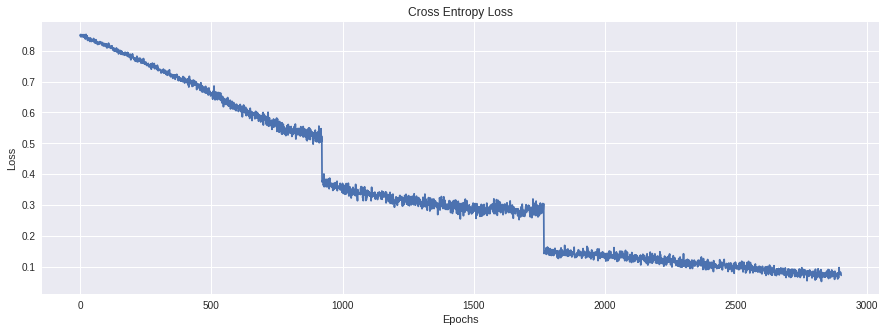

In [0]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Plotting Offloading decisions loss

plt.figure(figsize=(15, 5))
plt.title('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(array_loss)


plt.savefig('/content/drive/My Drive/TFM/graphs/offloading_loss.png', format='png', dpi=600)
plt.savefig('/content/drive/My Drive/TFM/graphs/offloading_loss.eps', format='eps', dpi=1000)

plt.show()

### Plot time cost

In [0]:
# Time cost for each input under different number of DNN
NN2 = 1060.8336
NN3 = 1696.8844
NN5 = 2083.7886
NN7 = 2896.8456

y = [NN2, NN3, NN5, NN7]

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
x = [0.6, 1.2, 1.8, 2.4]
width = 0.3
ax1.bar(x[0], y[0], width=width, label='NN = 2',fc = '#db3f3f')
ax1.text(x[0]-0.12, 1.01*y[0], str(y[0]), fontsize=20)
ax1.bar(x[1], y[1], width=width, label='NN = 3',fc = '#77d879')  
ax1.text(x[1]-0.12, 1.01*y[1], str(y[1]), fontsize=20)
ax1.bar(x[2], y[2], width=width, label='NN = 4',fc = '#0079a3')
ax1.text(x[2]-0.12, 1.01*y[2], str(y[2]), fontsize=20)
ax1.bar(x[3], y[3], width=width, label='NN = 5',fc = '#FF8C00')
ax1.text(x[3]-0.12, 1.01*y[3], str(y[3]), fontsize=20)


plt.xticks(x, ['NN2', 'NN3','NN4', 'NN5'])
# ax1.set_ylim([0.03, 0.1])
# plt.yticks([0.04, 0.05, 0.06, 0.07, 0.08])
ax1.tick_params(labelsize=20) 
ax1.set_ylabel('Time Cost(s)', fontsize=25)
ax1.set_xlabel('Number of NNs', fontsize=25)
ax1.grid(True, linestyle = "--", lw=0.3)

ax1.legend(loc='upper center', ncol=2, fontsize=20) 

plt.savefig('/content/drive/My Drive/TFM/graphs/time_cost.png', format='png', dpi=600)
#plt.savefig('/content/drive/My Drive/TFM/graphs/time_cost.eps', format='eps', dpi=1000)
plt.show()




# Time cost for each input under different learning rates
lr00001 =  6587.9883
lr0001 = 1637.9706
lr001 =  2098.6918
lr01 = 1622.8770 

y = [lr00001, lr0001, lr001, lr01]

fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)
x = [0.6, 1.2, 1.8, 2.4]
width = 0.3
ax1.bar(x[0], y[0], width=width, label='lr = 0.0001',fc = '#db3f3f')
ax1.text(x[0]-0.12, 1.01*y[0], str(y[0]), fontsize=20)
ax1.bar(x[1], y[1], width=width, label='lr = 0.001',fc = '#77d879')  
ax1.text(x[1]-0.12, 1.01*y[1], str(y[1]), fontsize=20)
ax1.bar(x[2], y[2], width=width, label='lr = 0.01',fc = '#0079a3')
ax1.text(x[2]-0.12, 1.01*y[2], str(y[2]), fontsize=20)
ax1.bar(x[3], y[3], width=width, label='lr = 0.1',fc = '#FF8C00')
ax1.text(x[3]-0.12, 1.01*y[3], str(y[3]), fontsize=20)


plt.xticks(x, ['lr00001', 'lr0001', 'lr001', 'lr01'])
# ax1.set_ylim([0.03, 0.1])
# plt.yticks([0.04, 0.05, 0.06, 0.07, 0.08])
ax1.tick_params(labelsize=20) 
ax1.set_ylabel('Time Cost(s)', fontsize=25)
ax1.set_xlabel('Learning rate', fontsize=25)
ax1.grid(True, linestyle = "--", lw=0.3)

ax1.legend(loc='upper center', ncol=2, fontsize=20) 

plt.savefig('/content/drive/My Drive/TFM/graphs/time_cost.png', format='png', dpi=600)
#plt.savefig('/content/drive/My Drive/TFM/graphs/time_cost.eps', format='eps', dpi=1000)
plt.show()

### Defining NN

In [0]:
# Defining Pytorch Neural Network
import torch

class NN(torch.nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size, batch_size, mem_size, net_num):
        super(NN, self).__init__()
        
        self.input_size = input_size
        self.hidden1_size = hidden1_size
        self.hidden2_size = hidden2_size
        self.output_size = output_size
        
        self.batch_size = batch_size
        self.net_num = net_num
        
        self.mem_size = mem_size 
        self.memory_counter = 1
        
        # initialize zero matrix memory [h, m] 
        self.mem = np.zeros((self.mem_size, self.input_size + self.output_size))
        self.df_mem = pd.DataFrame(np.random.randint(0,1,size=(self.mem_size,self.input_size + self.output_size)))
        
        
        # Layers
        
        self.hidden1 = torch.nn.Linear(input_size, hidden1_size)
        self.hidden2 = torch.nn.Linear(hidden1_size, hidden2_size)
        self.output = torch.nn.Linear(hidden2_size, output_size)
        
        self.sample_index=[]
        self.batch_memory=[]
        self.tasks=[]
        self.off_dec=[]
        

    def forward(self, x):
#       Sigmoid outputs between range [0,1]
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = torch.sigmoid(self.output(x))
        return x
      
    def memory(self, h, m):

        idx = self.memory_counter % self.mem_size
        self.mem[idx, :] = np.hstack((h,m))
        self.df_mem = pd.DataFrame(self.mem,index=self.mem[:,0])
        self.memory_counter += 1
        

    def batch(self):
        # sample batch memory from all memory
        self.sample_index.clear()
        self.batch_memory.clear()
        self.tasks.clear()
        self.off_dec.clear()
        if self.memory_counter > self.mem_size:
            
            # random array with batch_size
            self.sample_index.append(np.random.choice(self.mem_size, size=self.batch_size))  
            
        else:
            
            self.sample_index.append(np.random.choice(self.memory_counter, size=self.batch_size))
           
        self.batch_memory.append(self.mem[self.sample_index[0], :])
        self.tasks.append(self.batch_memory[0][:, 0:self.input_size])
        self.off_dec.append(self.batch_memory[0][:, self.input_size:])

        return self.tasks, self.off_dec

### System Utility

In [0]:

import numpy as np
import pandas as pd

class compute_Off(object):
    def __init__(self,N,M):
        #users and tasks
        self.N = N
        self.M = M
        #dataframe's index and columns 
        self.users=['user%d'%(i+1) for i in range(N)]
        self.wload=['w%d'%(i+1) for i in range(M)]
        self.Task=['Task%d'%(i+1) for i in range(M)] 
        np.random.seed(1)
        
        self.Data=pd.DataFrame(np.random.randint(0,150,size=(N,M)),index=self.users,columns=self.wload)
        
        self.X=pd.DataFrame(np.random.randint(0,2,size=(N,M)),index=self.users,columns=self.Task)
        self.C=pd.DataFrame(np.random.rand(N,1),index=self.users,columns=['bw'])
        self.XC = pd.concat([self.X, self.C], axis=1,join_axes=[self.Data.index])
        
        
        
    def compute_utility(self,task_size,M, bw):
        
        self.Data.iloc[0,0:3]=task_size[0:3]
        self.Data.iloc[1,0:3]=task_size[3:6]
        self.Data.iloc[2,0:3]=task_size[6:9]
        
        
        #fixed parameters
        task=2640 # Workload density (cycles/bit) face recognition
        fc=10.*10**9  # CPU rate of the edge sever
        er=2.77*10**-7 # receiving energy consumption of the mobile device (J/bit)
        et=6.5*10**-7 # transmission energy consumption of the mobile device (J/bit)
        El=3.61*10**-6 # local processing energy consumption (J/bit)
        Tl=2.64*10**-6 # local computation time of the mobile device (s/bit)
        BW=100
        
        b1 = bw[0]
        b2 = bw[1]
        b3 = bw[2]
        
        #Bandwidth allocation problem
        for i in range(self.N):
            
            self.XC.loc['user%d'%(i+1),['bw']]= (bw[i]*BW*8)/(sum(bw))
 
        self.Data['d'] = pd.Series([self.Data.loc[['user%d'%(i+1)],'w1':'w%d'%self.M] for i in range(self.N)], index=self.users)
        # the local energy consumption (Local computing)
        # El_nm = d_nm * el_n  Specifically, we use el_n to denote the local energy consumption per data bit of user n. Thus, user n’s energy
        self.Data['El'] = pd.Series([self.Data.loc[['user%d'%(i+1)],'w1':'w%d'%self.M]*El for i in range(self.N)], index=self.users)
        
        #transmission energy consumption (Edge computing)
        # Et_nm as the energy consumed by WDs for uploawloadg its workload to the edge server
        self.Data['et'] = pd.Series([self.Data.loc[['user%d'%(i+1)],'w1':'w%d'%self.M]*et for i in range(self.N)], index=self.users)
        self.Data['er'] = pd.Series([self.Data.loc[['user%d'%(i+1)],'w1':'w%d'%self.M]*er for i in range(self.N)], index=self.users)
        #energy consumption of the edge server
        # Ec_nm= et_nm + α*d_nm, the total cost for user n to offload its task m tothe edge server as:
        self.Data['EC'] = (self.Data.loc[:,'et'] + self.Data.loc[:,'er'])
       
        #local time delay 
        # Tl_nm = d_nm * tl. we denote user n’s local processing time per data bit as tl. the total processing time for user n to execute its task m is given by:
        self.Data['TL'] = pd.Series([self.Data.loc[['user%d'%(i+1)],'w1':'w%d'%self.M]*Tl for i in range(self.N)], index=self.users)
        
        #transmission delay 
        # Tt_nm = d_nm * c_ n , when user n offloads its task m to the edge server is given by:
        self.Data['Tt'] = pd.Series([self.Data.loc[['user%d'%(i+1)],'w1':'w%d'%self.M]/self.XC.loc['user%d'%(i+1),'bw'] for i in range(self.N)], index=self.users)
        
        #The edge server delay
        # Tc_nm = d_nm / fc , where we denote fc as the edge processing rate
        self.Data['Tc'] = pd.Series([self.Data.loc[['user%d'%(i+1)],'w1':'w%d'%self.M]*task/fc for i in range(self.N)], index=self.users)
        
        # Offloading results 
        self.XC.iloc[0,0:3]=M[:3]
        self.XC.iloc[1,0:3]=M[3:6]
        self.XC.iloc[2,0:3]=M[6:9]
        
        gain=0
        
        for i in range(self.N):
            # Q(d, x, c) =sum 1:N (sum 1:M ( El_nm(1 − x_nm) + Ec_nm * x_nm) + max{Tl, Tc})
            sum1=(self.Data.loc['user%d'%(i+1),'El']*(np.array(self.XC.loc['user%d'%(i+1),'Task1':'Task%d'%self.M]))+self.Data.loc['user%d'%(i+1),'EC']*(1-np.array(self.XC.loc['user%d'%(i+1),'Task1':'Task%d'%self.M]))).iloc[0,0:].sum()
            #Tl_n = sum 1:M (Tl_nm * (1 − x_nm)
            Tl=(self.Data.loc['user%d'%(i+1),'TL']*(np.array(self.XC.loc['user%d'%(i+1),'Task1':'Task%d'%self.M]))).iloc[0,0:].sum()
            #Tc_n = sum 1:M (Tt_nm + Tc_nm) * x_nm where Tt_nm = d_nm * c_ n
            Tc=((self.Data.loc['user%d'%(i+1),'Tt']+self.Data.loc['user%d'%(i+1),'Tc'])*(1-np.array(self.XC.loc['user%d'%(i+1),'Task1':'Task%d'%self.M]))).iloc[0,0:].sum()
            
            gain+=sum1+max(Tl,Tc)
            
        return gain

### Greedy optimal policy

In [0]:
import numpy as np
import pandas as pd
# from compute_Off import compute_Off
import random
#Greedy
from itertools import product

users = 3
tasks = 3
util = compute_Off(users,tasks)


task_size = np.load('/content/drive/My Drive/TFM/offloading_data/task_size/task_size.npy')
BW_users = np.load('/content/drive/My Drive/TFM/offloading_data/task_size/bw_users.npy')



lis = []
num_train = int(.7* len(task_size))
N = len(task_size)
num_test = len(task_size) - num_train # training data size
for prod in product(range(0, 2), repeat=9):
    lis.append(prod)
    ##print(prod)
#print ('lis size', len(lis))
gain_min = []
for i in range(N):
    if i < N - num_test:
        index = i % num_train
    else:
        index = i - N + num_test + num_train
    t1 = task_size[index,:]
    # print(t1)

    lis1 = []

    bw_list = []
    for m in lis:

        for n in range(users):
            bw = BW_users[n][i]
            #bw=3
            bw_list.append(bw)
            #print(bw_list)
        lis1.append(util.compute_utility(t1,m, bw_list))

    util_min = min(lis1)
    #print(util_min)
    gain_min.append(util_min)
    print(gain_min)
    if i % (N//100):
        print('Rate of progress: %0.2f' %(i*100/N))
    print ('util_max', util_min)

np.save('/Users/hector/Downloads/gain.npy', gain_min)
np.savetxt('/Users/hector/Downloads/gain_min.csv', gain_min, delimiter=",")

[6.25e-05]
util_max 6.25e-05
[6.25e-05, 5.625e-05]
Rate of progress: 0.01
util_max 5.625e-05


KeyboardInterrupt: ignored